#### Assessing Marketplace Accessibility: Isochrones for Marketplaces and Supermarkets in Quezon City

Janssens & Sezer (2013). Marketplaces as an Urban Development Strategy (Editorial). Built Environment, 39: 10.2148/benv.39.2.169

Markets act as:
- commercial gathering places
- vivid & inclusive public spaces
- nexus of flows of people, goods, and information
- sources of: 
    - fresh & affordable food, 
    - economic opportunities, and 
    - chances to socialize
- engines for sustainable urban growth
- sites to get a pulse of a city
- domains of public discontent & dispute
- sites of congestion, chaos, illegality
- romantic images for late capitalist urban gentrification
- centers of social movements and grassroots initiatives

#### Where the Jobs Are: Analysis of Office Density in Metro Manila

##### Research Questions:
- What is the distribution of office buildings in Metro Manila?
- What are the dominant clusters of office space in Metro Manila?
- How much office space is there per city in Metro Manila?

Step 0: Set Up Workspace

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import contextily as cx
import numpy as np

In [2]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

Step 1: Data Acquisition

To start, we will first extract all map features with an `office` tag.

In [3]:
# Define place name as Metro Manila
PLACE_NAME = ("Metro Manila, Philippines")

In [4]:
# # Extract Metro Manila boundary polygon
# area = ox.geocode_to_gdf(PLACE_NAME)
# area

In [5]:
# area.plot()

In [6]:
# Extract all offices in Metro Manila
offices = ox.features_from_place(
    PLACE_NAME,
    {
        "building:levels": [str(i) for i in range(10,100)]
    }
)

In [7]:
offices.head()

geometry  \
element_type osmid                                                           
node         5163397175                         POINT (121.07877 14.60992)   
way          18585116    POLYGON ((120.98803 14.60846, 120.98819 14.608...   
             22480435    POLYGON ((120.99277 14.56517, 120.99300 14.564...   
             22480452    POLYGON ((120.99222 14.56687, 120.99220 14.566...   
             22648530    POLYGON ((121.02525 14.55591, 121.02491 14.555...   

                        wheelchair amenity addr:city addr:postcode  \
element_type osmid                                                   
node         5163397175        NaN     NaN       NaN           NaN   
way          18585116          yes     NaN    Manila           NaN   
             22480435          NaN     NaN    Manila           NaN   
             22480452          NaN     NaN    Manila           NaN   
             22648530          NaN     NaN    Makati          1226   

                          addr:street  \
element_type osmid                      
node         5163397175           NaN   
way          18585116    Tamayo Drive   
             22480435             NaN   
             22480452             NaN   
             22648530    Ayala Avenue   

                                                               name office  \
element_type osmid                                                           
node         5163397175                                         NaN    NaN   
way          18585116    Buenaventura Garcia Paredes, O.P. Building    NaN   
             22480435                             Henry Sy Sr. Hall    NaN   
             22480452                Enrique M. Razon Sports Center    NaN   
             22648530                          The Peninsula Manila    NaN   

                        phone                                  website  ...  \
element_type osmid                                                      ...   
node         5163397175   NaN                                      NaN  ...   
way          18585116     NaN                                      NaN  ...   
             22480435     NaN                                      NaN  ...   
             22480452     NaN                                      NaN  ...   
             22648530     NaN  https://manila.peninsula.com/en/default  ...   

                        reservation non_existent_levels source:name was:name  \
element_type osmid                                                             
node         5163397175         NaN                 NaN         NaN      NaN   
way          18585116           NaN                 NaN         NaN      NaN   
             22480435           NaN                 NaN         NaN      NaN   
             22480452           NaN                 NaN         NaN      NaN   
             22648530           NaN                 NaN         NaN      NaN   

                        building:units year_of_construction ways type  \
element_type osmid                                                      
node         5163397175            NaN                  NaN  NaN  NaN   
way          18585116              NaN                  NaN  NaN  NaN   
             22480435              NaN                  NaN  NaN  NaN   
             22480452              NaN                  NaN  NaN  NaN   
             22648530              NaN                  NaN  NaN  NaN   

                        heritage construction_year  
element_type osmid                                  
node         5163397175      NaN               NaN  
way          18585116        NaN               NaN  
             22480435        NaN               NaN  
             22480452        NaN               NaN  
             22648530        NaN               NaN  

[5 rows x 159 columns]

Next, let us examine the data and see which information is most relevant. We can drop the columns we don't need.

In [8]:
offices.shape

(2784, 159)

In [9]:
offices.columns.values

array(['geometry', 'wheelchair', 'amenity', 'addr:city', 'addr:postcode',
       'addr:street', 'name', 'office', 'phone', 'website',
       'addr:province', 'access', 'mapillary', 'parking', 'survey:date',
       'description', 'emergency', 'fee', 'lit', 'opening_hours',
       'smoothness', 'supervised', 'surface', 'addr:housename', 'level',
       'surveillance', 'surveillance:type', 'building', 'building:levels',
       'brand', 'brand:wikidata', 'brand:wikipedia', 'official_name',
       'healthcare', 'shop', 'layer', 'operator', 'brand:instagram',
       'check_date', 'name:en', 'old_name', 'addr:housenumber',
       'payment:cash', 'payment:credit_cards', 'payment:debit_cards',
       'source', 'height', 'note', 'addr:country', 'addr:quarter',
       'frequency', 'wikipedia', 'nodes', 'alt_name', 'architect',
       'short_name', 'smoking', 'building:min_level',
       'building:architecture', 'leisure', 'sport', 'addr:street:corner',
       'tourism', 'wikidata', 'wikimedia_com

In [10]:
offices.isna().sum()

geometry                   0
wheelchair              2755
amenity                 2770
addr:city               1955
addr:postcode           2451
                        ... 
year_of_construction    2783
ways                    2752
type                    2752
heritage                2783
construction_year       2783
Length: 159, dtype: int64

In [11]:
offices["nodes"].isna().sum()

1

In [12]:
na_cutoff = len(offices) * 0.75

In [13]:
drop_cols = []

for col in offices:
    if offices[col].isna().sum() >= na_cutoff:
        drop_cols.append(col)

offices.drop(columns=drop_cols, inplace=True)

In [14]:
offices.columns.values

array(['geometry', 'addr:city', 'name', 'building', 'building:levels',
       'height', 'nodes', 'building:part'], dtype=object)

In [15]:
offices.isna().sum()

geometry              0
addr:city          1955
name               1198
building           1098
building:levels       0
height              723
nodes                 1
building:part      1687
dtype: int64

In [16]:
offices.head()

geometry  \
element_type osmid                                                           
node         5163397175                         POINT (121.07877 14.60992)   
way          18585116    POLYGON ((120.98803 14.60846, 120.98819 14.608...   
             22480435    POLYGON ((120.99277 14.56517, 120.99300 14.564...   
             22480452    POLYGON ((120.99222 14.56687, 120.99220 14.566...   
             22648530    POLYGON ((121.02525 14.55591, 121.02491 14.555...   

                        addr:city                                        name  \
element_type osmid                                                              
node         5163397175       NaN                                         NaN   
way          18585116      Manila  Buenaventura Garcia Paredes, O.P. Building   
             22480435      Manila                           Henry Sy Sr. Hall   
             22480452      Manila              Enrique M. Razon Sports Center   
             22648530      Makati                        The Peninsula Manila   

                           building building:levels height  \
element_type osmid                                           
node         5163397175         yes              28    NaN   
way          18585116        school              12   42.9   
             22480435    university              15   53.6   
             22480452           yes              10    NaN   
             22648530         hotel              11   41.1   

                                                                     nodes  \
element_type osmid                                                           
node         5163397175                                                NaN   
way          18585116    [191682731, 191682755, 7119882047, 7119882046,...   
             22480435    [241231894, 241231895, 7604181154, 7604181158,...   
             22480452    [241233167, 7755169338, 7755169340, 4089307758...   
             22648530    [242858533, 319959483, 319959485, 319959486, 5...   

                        building:part  
element_type osmid                     
node         5163397175           NaN  
way          18585116             NaN  
             22480435             NaN  
             22480452             NaN  
             22648530             NaN

Let us plot the offices on a map to see what we have. But first, let's ensure that the CRS is pseudo-mercator for web-mapping.

In [17]:
offices.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
offices.to_crs("EPSG:3857", inplace=True)

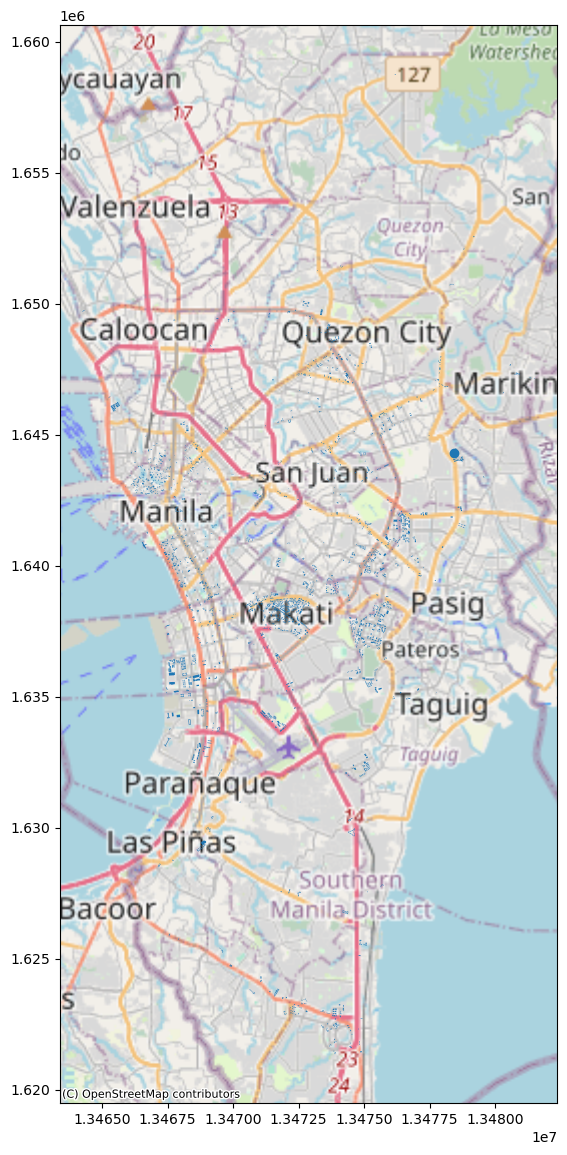

In [19]:
ax = offices.plot(
    figsize=(8,14),
    legend=True
)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

In [20]:
# Filter out non-polygon geometries
offices = offices.loc[offices["geometry"].geom_type != "Point"]
offices.head()

geometry  \
element_type osmid                                                         
way          18585116  POLYGON ((13468325.380 1644116.963, 13468343.4...   
             22480435  POLYGON ((13468853.602 1639137.852, 13468878.6...   
             22480452  POLYGON ((13468791.797 1639333.345, 13468790.5...   
             22648530  POLYGON ((13472469.114 1638072.448, 13472431.6...   
             22788808  POLYGON ((13472041.091 1638257.409, 13472053.8...   

                      addr:city                                        name  \
element_type osmid                                                            
way          18585116    Manila  Buenaventura Garcia Paredes, O.P. Building   
             22480435    Manila                           Henry Sy Sr. Hall   
             22480452    Manila              Enrique M. Razon Sports Center   
             22648530    Makati                        The Peninsula Manila   
             22788808    Makati                            Philamlife Tower   

                         building building:levels height  \
element_type osmid                                         
way          18585116      school              12   42.9   
             22480435  university              15   53.6   
             22480452         yes              10    NaN   
             22648530       hotel              11   41.1   
             22788808  commercial              48    200   

                                                                   nodes  \
element_type osmid                                                         
way          18585116  [191682731, 191682755, 7119882047, 7119882046,...   
             22480435  [241231894, 241231895, 7604181154, 7604181158,...   
             22480452  [241233167, 7755169338, 7755169340, 4089307758...   
             22648530  [242858533, 319959483, 319959485, 319959486, 5...   
             22788808  [244891956, 244891957, 244891958, 244891959, 2...   

                      building:part  
element_type osmid                   
way          18585116           NaN  
             22480435           NaN  
             22480452           NaN  
             22648530           NaN  
             22788808           NaN

In [21]:
# Get centroids
offices["centroid"] = offices.centroid

# Get coordinates of office points
coords = offices["centroid"].get_coordinates()
coords

c:\Users\Kurt\miniconda3\envs\geopython\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


x             y
element_type osmid                               
way          18585116  1.346835e+07  1.644104e+06
             22480435  1.346889e+07  1.639122e+06
             22480452  1.346875e+07  1.639340e+06
             22648530  1.347247e+07  1.637961e+06
             22788808  1.347208e+07  1.638247e+06
...                             ...           ...
relation     15905165  1.347305e+07  1.640006e+06
             15907851  1.347309e+07  1.639898e+06
             15907853  1.347317e+07  1.639840e+06
             15907890  1.347310e+07  1.639984e+06
             16244047  1.347315e+07  1.639946e+06

[2783 rows x 2 columns]

In [22]:
offices["x"] = coords.x
offices["y"] = coords.y

c:\Users\Kurt\miniconda3\envs\geopython\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Kurt\miniconda3\envs\geopython\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [28]:
offices.dtypes

geometry           geometry
addr:city            object
name                 object
building             object
building:levels      object
height               object
nodes                object
building:part        object
centroid           geometry
x                   float64
y                   float64
dtype: object

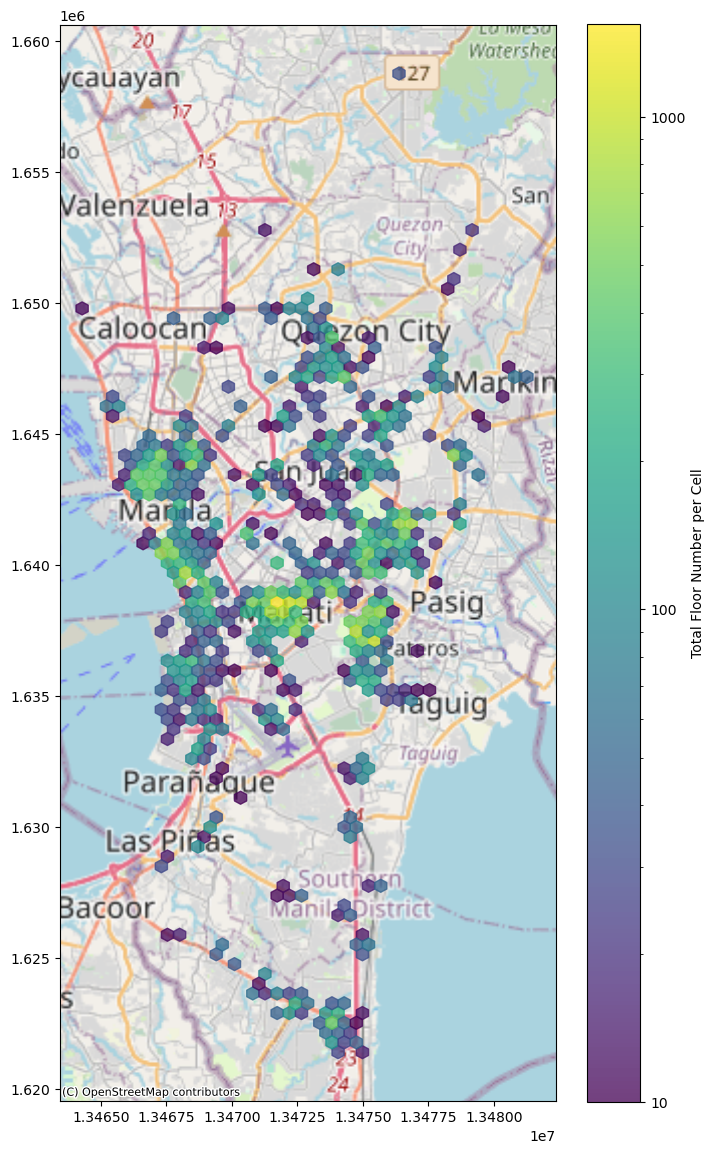

In [40]:
import matplotlib.ticker as ticker

fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(8,14))

hb = ax2.hexbin(
    offices["x"],
    offices["y"],
    C=offices["building:levels"].astype(int),
    gridsize=(37, 50),
    bins="log",
    alpha=0.75,
    reduce_C_function=np.sum,
)

cb = fig.colorbar(
    hb, 
    ax=ax2, 
    label="Total Floor Number per Cell",
    format=ticker.LogFormatter()
)

cx.add_basemap(ax2, source=cx.providers.OpenStreetMap.Mapnik)